# PhillyRouteFinder Project

## Introduction

In this project, I aim to explore the question of how one can travel from point A to point B safely in Philadelphia in certain time of day, in other words, finding the safest route for the individual that will make the trip. The resulting dashboard will allow the users to type in the origin, destination, and the time of departure. The product will also provide its users with three mode options: driving, bicycling, and walking. For driving, the recommended route will try to avoid places with a high frequency of crashes; for biking, it will take a bike route with the lowest probability of crashes; and when it comes to walking, it will steer clear of locations where crimes are most likely to take place.

The analysis techniques I’m going to employ in the following sections include spatial joins, filtering dataset based on time, location, and other criteria, grouping by certain columns to get the summary statistics, urban streets networks analysis ([graph theory](http://benalexkeen.com/implementing-djikstras-shortest-path-algorithm-with-python/)), among others. The datasets that will be used mainly come from:

1.	[Incidents in Philadelphia](https://cityofphiladelphia.github.io/carto-api-explorer/#incidents_part1_part2);
2.	[Crashes within Philadelphia](https://crashinfo.penndot.gov/PCIT/welcome.html) from 2013 to 2017, and
3.	Urban Street Network (from [osmnx](https://osmnx.readthedocs.io/en/stable/))


First, we need to import the packages that will be used during analyses.

In [1]:
# Import stuff
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import base64

import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut
from folium.plugins import HeatMap

from pyrestcli.auth import NoAuthClient
from carto.sql import SQLClient

import altair as alt
import holoviews as hv
import geoviews.tile_sources as gts
import param as pm
import panel as pn

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
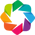

In [2]:
# Enable Altair and Holoviews rendering in the notebook
alt.renderers.enable('notebook')
hv.extension('bokeh')

In [3]:
# Add the Vega extension for Panel
pn.extension('vega')

## Prototyping Three Scenarios

In this section, we will go through three different scenarios, i.e. traveling by car, by bike, and on foot. I will use UPenn's Van Pelt Library -> Philadelphia Museum of Art as an example to describe how the route is generated. What this prototyping section aims to achieve is to explain how the final app will behave according to different user inputs.

### Step 1. Get coordinates of origin and destination

The app will apply geocoding according to the users' input locations. The purpose of the do_geocode function below is to avoid GeocoderTimedOut error.

In [4]:
orig_address = input('Where would you like to begin your trip?  ')  # Type in 3420 Walnut Street
orig_address = orig_address + ', Philadelphia'

Where would you like to begin your trip?  3420 Walnut Street


In [5]:
dest_address = input('Where would you like to go?   ') # Type in 2600 Benjamin Franklin Pkwy
dest_address = dest_address + ', Philadelphia'

Where would you like to go?   2600 Benjamin Franklin Pkwy


In [6]:
def do_geocode(address):
    geolocator = Nominatim(user_agent="my-application")
    
    try:
        return geolocator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

Let's get a sense of how far these two places are apart (though this distance measurement will not be included in the app). Please note that it calculates Euclidean distance here, instead of network distance.

In [7]:
orig = do_geocode(orig_address)
orig_coor = (orig.latitude, orig.longitude)

dest = do_geocode(dest_address)
dest_coor = (dest.latitude, dest.longitude)

print(geodesic(orig_coor, dest_coor).meters, 'Meters')

1778.168676703547 Meters


### Step 2. Get Time

We'll get the current time using datetime.datetime.now() for demo. In the app, the users are able to choose the time they want to depart.

In [8]:
now = datetime.datetime.now()
hour = now.hour

print(hour)

17


### Step 3. Different Traveling Modes

In this step, we will discuss three available travel modes separately.

### 3.1 Automobile

#### Get nearest nodes & graph

To calculate a shortest path, the road network data from the osmnx library is necessary. In the following cells, I compute the coordinates of the mid point (between origin and destination), and then use it combining with a set distance to get the graph. The goal here is to get a region that is as small as possible to minimize the potential amount of computation when doing spatial join and other related operations later.

In [9]:
mid_coor = ((orig_coor[0]+dest_coor[0])/2, (orig_coor[1]+dest_coor[1])/2)

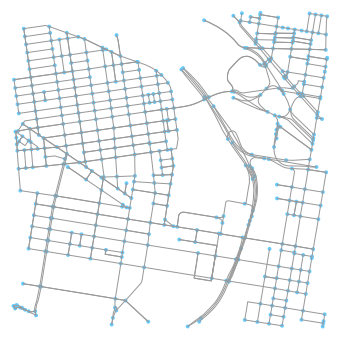

In [10]:
drive_graph = ox.graph_from_point(mid_coor, network_type='drive', distance=geodesic(orig_coor, dest_coor).meters/1.5)
ox.plot_graph(drive_graph);

The follow code is used to acquire the nearest node in the network for the origin and destination, respectively.

In [11]:
orig_node = ox.get_nearest_node(drive_graph, orig_coor) 
dest_node = ox.get_nearest_node(drive_graph, dest_coor) 

In [12]:
#route = nx.shortest_path(drive_graph, orig_node, dest_node, weight='length')
#route
#ox.plot_graph_route(drive_graph, route, node_size=0);

#### Get automobile crashes

Here, crashes datasets from 2013 to 2017 are loaded into the program. First, I project the columns that I need in each dataset, and then concatenate them into one single dataframe. In order to transform the combining dataset into a geodataframe, I add a Coordinates column with shapely's apply(Point) method. Lastly, the crashes point objects that are within the graph's boundary and the given hour will be processed into the next part of analysis.

In [13]:
crashes_2017 = pd.read_csv('Philadelphia_CRASH_2017.csv')
crashes_2016 = pd.read_csv('CRASH_2016_Philadelphia.csv')
crashes_2015 = pd.read_csv('CRASH_2015_Philadelphia.csv')
crashes_2014 = pd.read_csv('CRASH_2014_Philadelphia.csv')
crashes_2013 = pd.read_csv('CRASH_2013_Philadelphia.csv')

In [14]:
crash_17 = crashes_2017[['CRASH_YEAR', 'CRASH_MONTH', 'DAY_OF_WEEK', 'TIME_OF_DAY','HOUR_OF_DAY', 'DEC_LAT','DEC_LONG']]
crash_16 = crashes_2016[['CRASH_YEAR', 'CRASH_MONTH', 'DAY_OF_WEEK', 'TIME_OF_DAY','HOUR_OF_DAY', 'DEC_LAT','DEC_LONG']]
crash_15 = crashes_2015[['CRASH_YEAR', 'CRASH_MONTH', 'DAY_OF_WEEK', 'TIME_OF_DAY','HOUR_OF_DAY', 'DEC_LAT','DEC_LONG']]
crash_14 = crashes_2014[['CRASH_YEAR', 'CRASH_MONTH', 'DAY_OF_WEEK', 'TIME_OF_DAY','HOUR_OF_DAY', 'DEC_LAT','DEC_LONG']]
crash_13 = crashes_2013[['CRASH_YEAR', 'CRASH_MONTH', 'DAY_OF_WEEK', 'TIME_OF_DAY','HOUR_OF_DAY', 'DEC_LAT','DEC_LONG']]

crashes_df = pd.concat([crash_17, crash_16, crash_15, crash_14, crash_13]).reset_index(drop=True)

In [15]:
crashes_df['Coordinates'] = list(zip(crashes_df.DEC_LONG, crashes_df.DEC_LAT))
crashes_df['Coordinates'] = crashes_df['Coordinates'].apply(Point)
crashes_gdf = gpd.GeoDataFrame(crashes_df, geometry='Coordinates')

In [16]:
bounding_box = ox.bbox_from_point(mid_coor, distance=geodesic(orig_coor, dest_coor).meters/1.5)
boundary = ox.utils.bbox_to_poly(bounding_box[0], bounding_box[1], bounding_box[2], bounding_box[3])

In [17]:
bounding_box

(39.969819541110674, 39.94845823913292, -75.17384347081601, -75.20160208604837)

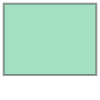

In [18]:
boundary

In [19]:
final_crashes = crashes_gdf[gpd.GeoSeries.within(crashes_gdf, boundary)]
final_crashes = final_crashes[final_crashes['HOUR_OF_DAY']==hour].reset_index(drop=True)

#### Spatial Join

What the following codes achieve is to find the nearest edge of each crash, calculate the total number of crashes of each street, and merge the crash count dataframe with the edges geodataframe.

In [20]:
drive_edge = ox.graph_to_gdfs(drive_graph, edges=True, nodes=False)

In [21]:
auto_lst = ox.get_nearest_edges(drive_graph, final_crashes.Coordinates.y, final_crashes.Coordinates.x)

In [22]:
auto_df = pd.DataFrame(auto_lst, columns=['u', 'v'])

In [23]:
auto_count = auto_df.groupby(['u', 'v']).size().reset_index(name='count')

In [24]:
auto_count_gdf = drive_edge.merge(auto_count, left_on=['u', 'v'], right_on=['u','v'], how='left')

In [25]:
auto_count_gdf['count'].fillna(0, inplace=True)

#### Weighted Shortest Path based on automobile crashes

Below, we will use Djikstra’s algorithm to calculate a weighted shortest path from the origin to the destination (weight being the number of crashes in this case). The algorithm fans away from the starting node by visiting the next node of the lowest weight and continues to do so until the next node of the lowest weight is the end node. In other words, it is a greedy algorithm.

We’ll start by constructing a graph class.

In [26]:
from collections import defaultdict

class Graph():
    def __init__(self):
        """
        self.edges is a dict of all possible next nodes
        e.g. {'X': ['A', 'B', 'C', 'E'], ...}
        self.weights has all the weights between two nodes,
        with the two nodes as a tuple as the key
        e.g. {('X', 'A'): 7, ('X', 'B'): 2, ...}
        """
        self.edges = defaultdict(list)
        self.weights = {}
    
    def add_edge(self, from_node, to_node, weight):
        '''
        Assuming we are dealing with oriented graphs
        '''
        self.edges[from_node].append(to_node)
        self.weights[(from_node, to_node)] = weight


Define a function that will generate a list of nodes with the desired inputs. (The code below is adapted based on this [website](http://benalexkeen.com/implementing-djikstras-shortest-path-algorithm-with-python/))

In [27]:
def dijsktra(graph, initial, end):
    '''
    shortest paths is a dict of nodes
    whose value is a tuple of (previous node, weight)
    '''
    shortest_paths = {initial: (None, 0)}
    current_node = initial
    visited = set()
    
    while current_node != end:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
        
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return "Route Not Possible"
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
    
    # Work back through destinations in shortest path
    path = []
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        current_node = next_node
    # Reverse path
    path = path[::-1]
    return path

The edges provided by osmnx are directed graphs, meaning nodes are not mutually connected unless specified. How the nodes are connected with one another is recorded in the oneway column. Here we will generate an adjacency list (a list of tuple specifically), which will include origin, destination, and weight in each element, and then pass it to our graph object.

In [28]:
edges = []

for index, row in auto_count_gdf.iterrows():
    if row['oneway']:
        edges.append((row['u'], row['v'], row['count']))
    else:
        edges.append((row['u'], row['v'], row['count']))
        edges.append((row['v'], row['u'], row['count']))

In [29]:
graph = Graph()

for edge in edges:
    graph.add_edge(*edge)

And shortest path is calculated.

In [30]:
route = dijsktra(graph, orig_node, dest_node)

In [31]:
route

[109987942,
 110142269,
 4477512949,
 110142236,
 109813507,
 2699560200,
 415465296,
 5372085242,
 363648591,
 635028824,
 110212244,
 2699476677,
 780907743,
 110212276,
 110212290,
 109800257,
 110114888,
 110114898,
 110114911,
 109788559,
 109782558,
 109784415,
 1586414602]

In [32]:
ox.plot_route_folium(drive_graph, route, route_color='#ffbbba', route_width=4, route_opacity=1)

The heatmap below is a way to check if the algorithm does a good job in avoiding the dangerous places. It does suggest the users not drive along Vine Street Expressway, where crashes are most likely to happen.

In [33]:
final_crashes['lat'] = final_crashes.Coordinates.y
final_crashes['lng'] = final_crashes.Coordinates.x
coordinates = final_crashes[['lat', 'lng']].values

In [34]:
m = ox.plot_route_folium(drive_graph, route, route_color='#ffbbba', route_width=4, route_opacity=1)

HeatMap(coordinates).add_to(m)

m

The following code blocks are to plot a histogram that tells us the total number of crashes of each street in the network shown by the route graph.

In [35]:
hist = auto_count_gdf[['name', 'count']]
hist = hist[hist['count']>0].dropna()

In [36]:
hist.head()

name  count
0              Kelly Drive    1.0
3        North 25th Street    1.0
7        North 22nd Street    2.0
8            Winter Street    4.0
12  Vine Street Expressway    6.0

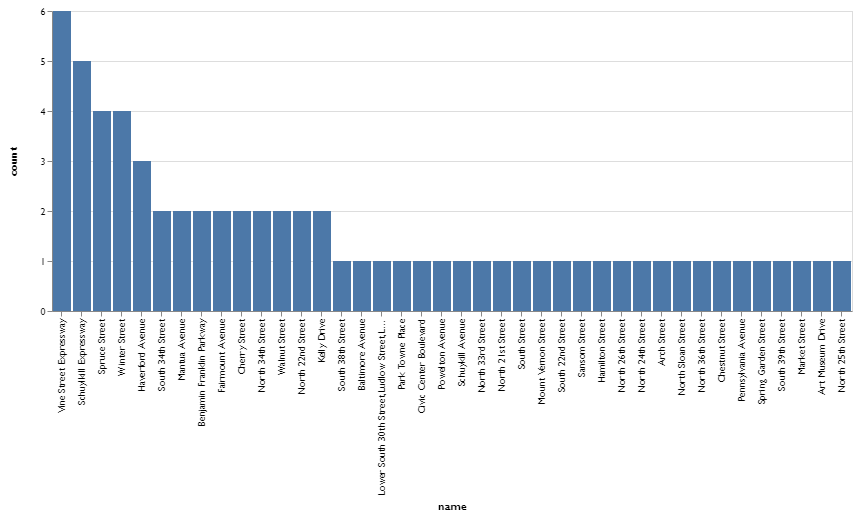

In [37]:
alt.Chart(hist).mark_bar().encode(
   alt.X('name:N', sort=alt.EncodingSortField(field="count", op="max", order='descending')),
   alt.Y('count:Q')).properties(width=800, height=300)

I also calculate the total network distance of the trip.

In [38]:
trip_length = 0

for i in range(len(ox.utils.get_route_edge_attributes(drive_graph, route))):
    trip_length += ox.utils.get_route_edge_attributes(drive_graph, route)[i]['length']

In [39]:
print('The length of your trip is', str(round(trip_length/1609.34, 2)), 'miles.')

The length of your trip is 1.4 miles.


### 3.2 Bicycle

#### Get nearest nodes & graph

Similarly, we will use the osmnx library to get a bike network graph. The approaches applied here are basically the same as the automobile section.

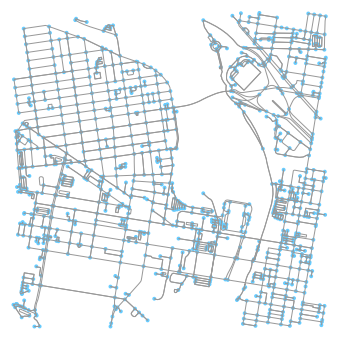

In [40]:
bike_graph = ox.graph_from_point(mid_coor, network_type='bike', distance=geodesic(orig_coor, dest_coor).meters/1.5)
ox.plot_graph(bike_graph);

In [41]:
orig_node = ox.get_nearest_node(bike_graph, orig_coor) 
dest_node = ox.get_nearest_node(bike_graph, dest_coor) 

#### Spatial Join

In [42]:
bike_edge = ox.graph_to_gdfs(bike_graph, edges=True, nodes=False)

In [43]:
bike_lst = ox.get_nearest_edges(bike_graph, final_crashes.Coordinates.y, final_crashes.Coordinates.x)

In [44]:
bike_df = pd.DataFrame(bike_lst, columns=['u', 'v'])
bike_count = bike_df.groupby(['u', 'v']).size().reset_index(name='count')
bike_count_gdf = bike_edge.merge(bike_count, left_on=['u', 'v'], right_on=['u','v'], how='left')
bike_count_gdf['count'].fillna(0, inplace=True)

#### Weighted Shortest Path based on bicycle crashes

In [45]:
edges = []

for index, row in bike_count_gdf.iterrows():
    if row['oneway']:
        edges.append((row['u'], row['v'], row['count']))
    else:
        edges.append((row['u'], row['v'], row['count']))
        edges.append((row['v'], row['u'], row['count']))

In [46]:
graph = Graph()

for edge in edges:
    graph.add_edge(*edge)

In [47]:
route = dijsktra(graph, orig_node, dest_node)

In [48]:
route

[109987942,
 110142269,
 4477512949,
 110142236,
 360506516,
 109813507,
 2699560200,
 415465296,
 5372085242,
 363648591,
 2700377163,
 635028824,
 110212244,
 2699476677,
 780907743,
 110212276,
 110212290,
 109800257,
 109800249,
 2215719949,
 2215719950,
 109784415,
 109767544,
 109767488,
 482353116,
 4920530736,
 4920530734,
 4920530735]

In [49]:
m = ox.plot_route_folium(bike_graph, route, route_color='#ffbbba', route_width=4, route_opacity=1, tiles = 'CartoDB dark_matter')

HeatMap(coordinates).add_to(m)

m

In [50]:
hist = bike_count_gdf[['name', 'count']]
hist = hist[hist['count']>0].dropna()

In [51]:
hist.sort_values('count', ascending=False).iloc[0:5]

name  count
229            Winter Street    8.0
1111  Schuylkill River Trail    7.0
1113  Schuylkill River Trail    6.0
832            Spruce Street    4.0
790         Haverford Avenue    3.0

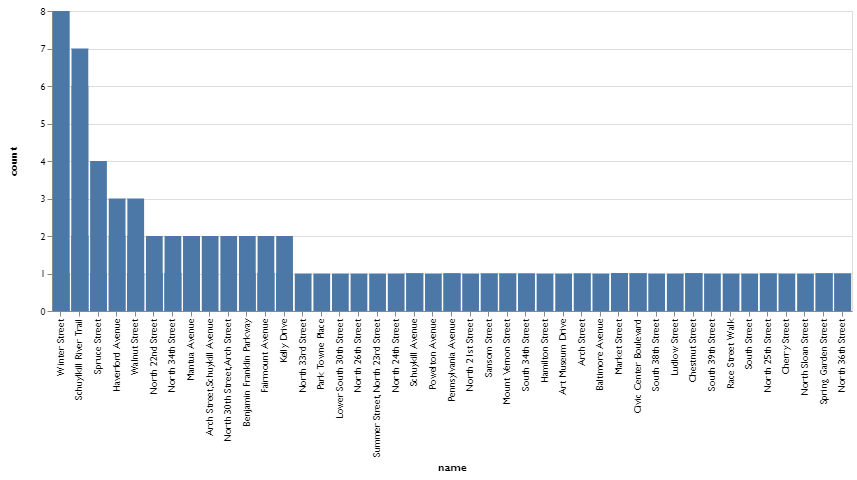

In [52]:
alt.Chart(hist).mark_bar().encode(
   alt.X('name:N', sort=alt.EncodingSortField(field="count", op="max", order='descending')),
   alt.Y('count:Q')).properties(width=800, height=300)

In [53]:
trip_length = 0

for i in range(len(ox.utils.get_route_edge_attributes(bike_graph, route))):
    trip_length += ox.utils.get_route_edge_attributes(bike_graph, route)[i]['length']

In [54]:
print('The length of your trip is', str(round(trip_length/1609.34, 2)), 'miles.')

The length of your trip is 1.63 miles.


### 3.3 Walking

#### Get nearest nodes & graph

As for the last available mode, namely walking, we will still need to acquire the correspondingly network graph from osmnx.

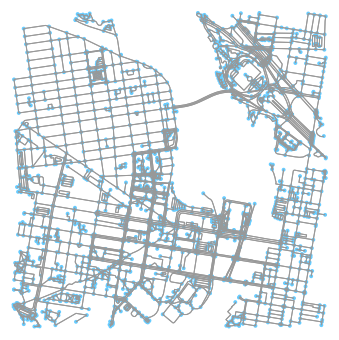

In [55]:
walk_graph = ox.graph_from_point(mid_coor, network_type='walk', distance=geodesic(orig_coor, dest_coor).meters/1.5)
ox.plot_graph(walk_graph);

In [56]:
orig_node = ox.get_nearest_node(walk_graph, orig_coor) 
dest_node = ox.get_nearest_node(walk_graph, dest_coor) 

#### Get crimes (based on location and time)

One of the difference between this section and the abovementioned ones is that carto API will be used to collect the data. We will download a dataset from the "incidents_part1_part2" table in the database using SQL query.

In [57]:
API_endpoint = "https://phl.carto.com"
sql_client = SQLClient(NoAuthClient(API_endpoint))

In [58]:
table_name = "incidents_part1_part2"
query = "SELECT * FROM {} WHERE hour_ = {}".format(table_name, hour)
#print(query)

In [59]:
features = sql_client.send(query, format='geojson')

incidents = gpd.GeoDataFrame.from_features(features, crs={'init':'epsg:4326'})
incidents.head(10)

C:\Users\MaiRZ\Anaconda3\envs\musa-620\lib\site-packages\pyrestcli\auth.py:79: UserWarning: You are using methods other than get with no authentication!!!
  warnings.warn(_("You are using methods other than get with no authentication!!!"))


cartodb_id dc_dist        dc_key dispatch_date    dispatch_date_time  \
0          11      01  201501006600    2015-02-24  2015-02-24T00:00:00Z   
1          53      02  201502042198    2015-07-01  2015-07-01T00:00:00Z   
2          59      01  201501001914    2015-01-17  2015-01-17T00:00:00Z   
3          64      01  201501004271    2015-02-05  2015-02-05T00:00:00Z   
4          70      01  201501040672    2015-09-20  2015-09-20T00:00:00Z   
5         151      02  201502040604    2015-06-24  2015-06-24T00:00:00Z   
6         178      01  201501026350    2015-07-05  2015-07-05T00:00:00Z   
7         187      01  201501029280    2015-07-22  2015-07-22T00:00:00Z   
8         188      01  201501029499    2015-07-23  2015-07-23T00:00:00Z   
9         196      01  201501033959    2015-08-17  2015-08-17T00:00:00Z   

  dispatch_time                              geometry  hour_  \
0      17:19:00          POINT (-75.175337 39.914722)     17   
1      17:14:00  POINT (-75.05967800000001 40.047657)     17   
2      17:52:00   POINT (-75.18126700000001 39.91663)     17   
3      17:20:00          POINT (-75.191546 39.924779)     17   
4      17:46:00          POINT (-75.181543 39.926403)     17   
5      17:52:00   POINT (-75.09958399999999 40.02849)     17   
6      17:55:00          POINT (-75.187844 39.922207)     17   
7      17:04:00  POINT (-75.18053500000001 39.926187)     17   
8      17:01:00          POINT (-75.173164 39.913756)     17   
9      17:54:00  POINT (-75.17246299999999 39.924692)     17   

                location_block  objectid    point_x    point_y psa  \
0      2800 BLOCK S SMEDLEY ST         5 -75.175337  39.914722   2   
1             2311 COTTMAN AVE       130 -75.059678  40.047657   3   
2         2800 BLOCK S 20TH ST       137 -75.181267  39.916630   2   
3          2700 BLOCK TREE TER       143 -75.191546  39.924779   1   
4      2000 BLOCK S NORWOOD ST       277 -75.181543  39.926403   1   
5  4600 BLOCK E ROOSEVELT BLVD       785 -75.099584  40.028490   1   
6    2400 BLOCK W PASSYUNK AVE        47 -75.187844  39.922207   1   
7          2000 BLOCK MERCY ST        58 -75.180535  39.926187   1   
8     2900 BLOCK S CARLISLE ST        59 -75.173164  39.913756   2   
9        1500 BLOCK SNYDER AVE        68 -75.172463  39.924692   1   

             text_general_code ucr_general  
0              Robbery Firearm         300  
1                       Thefts         600  
2               Other Assaults         800  
3               Other Assaults         800  
4  Vandalism/Criminal Mischief        1400  
5                       Thefts         600  
6                       Thefts         600  
7                       Thefts         600  
8                       Thefts         600  
9                       Thefts         600

The number of incidents are so large that it will slow the incoming spatial join operation quite a lot. As a result, I just keep the incidents happening from 2018 till now.

In [60]:
final_incidents = incidents[gpd.GeoSeries.within(incidents, boundary)].reset_index(drop=True)

In [61]:
final_incidents['dispatch_date_time'] = pd.to_datetime(final_incidents['dispatch_date_time'])

In [62]:
final_incidents['year'] = final_incidents['dispatch_date_time'].apply(lambda x : x.year)

In [63]:
final_incidents = final_incidents[final_incidents['year'] >= 2018].reset_index(drop=True)

In [64]:
final_incidents = final_incidents[['geometry', 'year', 'hour_']]

#### Spatial Join

The spatial join, generating shortest path, and plotting operations are the same as what are shown in the automobile and bike sections, so I'd better not repeat here.

In [65]:
walk_edge = ox.graph_to_gdfs(walk_graph, edges=True, nodes=False)

In [66]:
walk_lst = ox.get_nearest_edges(walk_graph, final_incidents.geometry.y, final_incidents.geometry.x)

In [67]:
walk_df = pd.DataFrame(walk_lst, columns=['u', 'v'])

In [68]:
walk_count = walk_df.groupby(['u', 'v']).size().reset_index(name='count')

In [69]:
walk_count_gdf = walk_edge.merge(walk_count, left_on=['u', 'v'], right_on=['u','v'], how='left')

In [70]:
walk_count_gdf['count'].fillna(0, inplace=True)

#### Weighted Shortest Path based on crimes

Instead of the number of crashes, the weight here refers to the number of incidents on each edge.

In [71]:
edges = []

for index, row in walk_count_gdf.iterrows():
    if row['oneway']:
        edges.append((row['u'], row['v'], row['count']))
    else:
        edges.append((row['u'], row['v'], row['count']))
        edges.append((row['v'], row['u'], row['count']))

In [72]:
graph = Graph()

for edge in edges:
    graph.add_edge(*edge)

In [73]:
route = dijsktra(graph, orig_node, dest_node)

In [74]:
route

[1762667064,
 360487042,
 2011484566,
 2011484572,
 3272478890,
 4550404641,
 109987964,
 110153531,
 109849780,
 4477512963,
 109813516,
 4161473002,
 4161472997,
 3404793638,
 3404793636,
 5562229755,
 109875366,
 110442698,
 4777004796,
 110398440,
 780907728,
 110435940,
 110432722,
 110031228,
 4777696364,
 110212339,
 110212347,
 110018730,
 110018726,
 110114911,
 109784415,
 6136430517,
 109767544,
 881792553,
 5941448392,
 6159600958,
 4144883381,
 482353116,
 4920530736,
 4920530735]

In [75]:
ox.plot_route_folium(walk_graph, route, route_color='#ffbbba', route_width=4, route_opacity=1)

In [76]:
final_incidents['lat'] = final_incidents.geometry.y
final_incidents['lng'] = final_incidents.geometry.x
coordinates = final_incidents[['lat', 'lng']].values

In [77]:
m = ox.plot_route_folium(walk_graph, route, route_color='#ffbbba', route_width=4, route_opacity=1, tiles = 'CartoDB dark_matter')

HeatMap(coordinates).add_to(m)

m

In [78]:
hist = walk_count_gdf[['name', 'count']]
hist = hist[hist['count']>0].dropna()

In [79]:
hist.head()

name  count
5         Spruce Street    6.0
7         Spruce Street    1.0
78   North Union Street    1.0
150       Market Street    4.0
172       Market Street    6.0

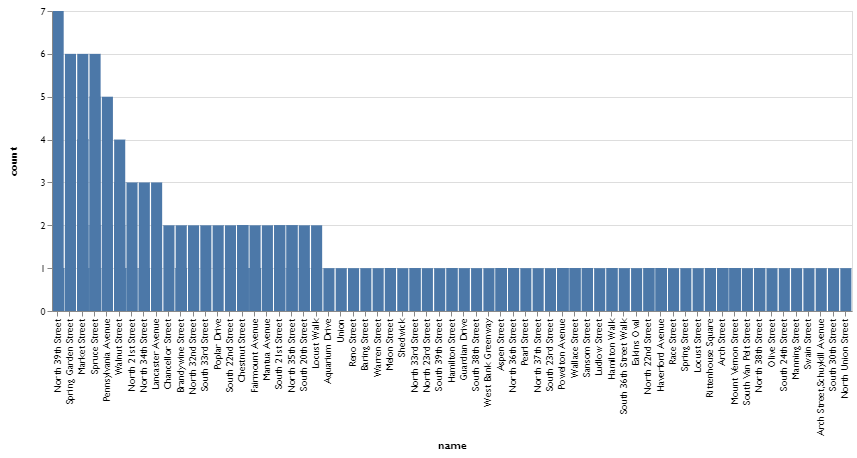

In [80]:
alt.Chart(hist).mark_bar().encode(
   alt.X('name:N', sort=alt.EncodingSortField(field="count", op="max", order='descending')),
   alt.Y('count:Q')).properties(width=800, height=300)

In [81]:
trip_length = 0

for i in range(len(ox.utils.get_route_edge_attributes(walk_graph, route))):
    trip_length += ox.utils.get_route_edge_attributes(walk_graph, route)[i]['length']

In [82]:
print('The length of your trip is', str(round(trip_length/1609.34, 2)), 'miles.')

The length of your trip is 1.87 miles.


------------------------------------

## Building the App

We'll define the app as a custom Python class that contains the various components of the dashboard, which include:

- The parameters we want the user to be able to change.
- Functions to generate the various charts/maps in our dashboard, based on those input parameters.
- The dependencies between our chart functions and parameters.

The workflow in the cell below is exactly what are presented in the prototyping section.

In [83]:
class RoutesApp(pm.Parameterized):
    '''
    doc string
    '''
    
    # Departure Hour
    hour = pm.Integer(9, bounds=(0, 23))
    
    # Customized origin and destination
    origin = pm.String(default="3701 Walnut Street", doc="Origin")
    destination = pm.String(default="2600 Benjamin Franklin Pkwy", doc="Destination")
    
    # Travel mode
    mode = pm.ObjectSelector(default="drive",objects=["drive","bike","walk"])
    
    # Tile of basemap
    basemap = pm.ObjectSelector(default="cartodbpositron",
                                objects=["openstreetmap","stamenterrain","stamentoner", 
                                         "cartodbpositron","cartodbdark_matter"])
    
    # Whether to show heatmap or not
    show_heatmap = pm.Boolean(False)
    
    
    @pm.depends("origin", "destination", watch=True)
    def delete_coor(self):
        if hasattr(self, '_coor'): del self._coor

 
    @property
    def coor(self):
        if not hasattr(self, "_coor"):
            orig_address = self.origin + ', Philadelphia'
            dest_address = self.destination + ', Philadelphia'

            orig = do_geocode(orig_address)
            orig_coor = (orig.latitude, orig.longitude)

            dest = do_geocode(dest_address)
            dest_coor = (dest.latitude, dest.longitude)

            # set 
            self._coor = orig_coor, dest_coor
        
        return self._coor
    
    def get_mid(self):
        orig_coor = self.coor[0]
        dest_coor = self.coor[1]
        
        mid_coor = ((orig_coor[0]+dest_coor[0])/2, (orig_coor[1]+dest_coor[1])/2)
        
        return mid_coor
    
    
    def get_boundary(self):
        bounding_box = ox.bbox_from_point(self.get_mid(), distance=geodesic(self.coor[0], self.coor[1]).meters/1.5)
        boundary = ox.utils.bbox_to_poly(bounding_box[0], bounding_box[1], bounding_box[2], bounding_box[3])
        
        return boundary
    
    
    @pm.depends("mode", "origin", "destination", watch=True)
    def delete_graph(self):
        if hasattr(self, "_graph"): del self._graph

    @property
    def graph(self):
        # create the graph if it doesn't exist
        if not hasattr(self, "_graph"):
            print("making graph...")
            graph = ox.graph_from_point(self.get_mid(), network_type=self.mode, 
                                    distance=geodesic(self.coor[0], self.coor[1]).meters/1.5)
        
            print("...done")
            self._graph = graph 
            
        return self._graph
            
        
    
    @pm.depends("mode", "hour", "origin", "destination", watch=True)
    def delete_filter_df(self):
        if hasattr(self, "_filter_df"): del self._filter_df
     
    @property
    def filter_df(self):
        if not hasattr(self, "_filter_df"):
            print("creating filter_df...")
            if self.mode == 'drive':
                final_crashes = crashes_gdf[gpd.GeoSeries.within(crashes_gdf, self.get_boundary())]
                final_crashes = final_crashes[final_crashes['HOUR_OF_DAY']==self.hour].reset_index(drop=True)

                drive_edge = ox.graph_to_gdfs(self.graph, edges=True, nodes=False)
                auto_lst = ox.get_nearest_edges(self.graph, final_crashes.Coordinates.y, final_crashes.Coordinates.x)
                auto_df = pd.DataFrame(auto_lst, columns=['u', 'v'])
                auto_count = auto_df.groupby(['u', 'v']).size().reset_index(name='count')
                auto_count_gdf = drive_edge.merge(auto_count, left_on=['u', 'v'], right_on=['u','v'], how='left')
                auto_count_gdf['count'].fillna(0, inplace=True)

                final_crashes['lat'] = final_crashes.Coordinates.y
                final_crashes['lng'] = final_crashes.Coordinates.x

                self._filter_df = final_crashes, auto_count_gdf

            elif self.mode == 'bike':
                final_crashes = crashes_gdf[gpd.GeoSeries.within(crashes_gdf, self.get_boundary())]
                final_crashes = final_crashes[final_crashes['HOUR_OF_DAY']==self.hour].reset_index(drop=True)

                bike_edge = ox.graph_to_gdfs(self.graph, edges=True, nodes=False)
                bike_lst = ox.get_nearest_edges(self.graph, final_crashes.Coordinates.y, final_crashes.Coordinates.x)
                bike_df = pd.DataFrame(bike_lst, columns=['u', 'v'])
                bike_count = bike_df.groupby(['u', 'v']).size().reset_index(name='count')
                bike_count_gdf = bike_edge.merge(bike_count, left_on=['u', 'v'], right_on=['u','v'], how='left')
                bike_count_gdf['count'].fillna(0, inplace=True)

                final_crashes['lat'] = final_crashes.Coordinates.y
                final_crashes['lng'] = final_crashes.Coordinates.x

                self._filter_df = final_crashes, bike_count_gdf
        
            elif self.mode == 'walk':
                table_name = "incidents_part1_part2"
                query = "SELECT * FROM {} WHERE hour_ = {}".format(table_name, self.hour)

                features = sql_client.send(query, format='geojson')
                incidents = gpd.GeoDataFrame.from_features(features, crs={'init':'epsg:4326'})

                final_incidents = incidents[gpd.GeoSeries.within(incidents, self.get_boundary())].reset_index(drop=True)
                final_incidents['dispatch_date_time'] = pd.to_datetime(final_incidents['dispatch_date_time'])
                final_incidents['year'] = final_incidents['dispatch_date_time'].apply(lambda x : x.year)
                final_incidents = final_incidents[final_incidents['year'] >= 2018].reset_index(drop=True)
                final_incidents = final_incidents[['geometry', 'year', 'hour_']]

                walk_edge = ox.graph_to_gdfs(self.graph, edges=True, nodes=False)
                walk_lst = ox.get_nearest_edges(self.graph, final_incidents.geometry.y, final_incidents.geometry.x)
                walk_df = pd.DataFrame(walk_lst, columns=['u', 'v'])
                walk_count = walk_df.groupby(['u', 'v']).size().reset_index(name='count')
                walk_count_gdf = walk_edge.merge(walk_count, left_on=['u', 'v'], right_on=['u','v'], how='left')
                walk_count_gdf['count'].fillna(0, inplace=True)

                final_incidents['lat'] = final_incidents.geometry.y
                final_incidents['lng'] = final_incidents.geometry.x

                self._filter_df = final_incidents, walk_count_gdf
            print("...done")
            
        return self._filter_df
    
    def get_node(self):
        orig_node = ox.get_nearest_node(self.graph, self.coor[0]) 
        dest_node = ox.get_nearest_node(self.graph, self.coor[1])
        
        return orig_node, dest_node
    
    
    def shortest_path(self):
        edges = []

        for index, row in self.filter_df[1].iterrows():
            if row['oneway']:
                edges.append((row['u'], row['v'], row['count']))
            else:
                edges.append((row['u'], row['v'], row['count']))
                edges.append((row['v'], row['u'], row['count']))
                
        graph = Graph()

        for edge in edges:
            graph.add_edge(*edge)
            
        return dijsktra(graph, self.get_node()[0], self.get_node()[1])
    
    
    @pm.depends("basemap", "show_heatmap", "hour", "origin", "destination", "mode")
    def route_graph(self):
        print("IN ROUTE GRAPH")
        G = ox.plot_route_folium(self.graph, self.shortest_path(), route_color='#ffbbba', route_width=4, 
                                 route_opacity=1, tiles = self.basemap)
        
        if self.show_heatmap:
            df = self.filter_df[0]
            coordinates = df[['lat', 'lng']].values
            HeatMap(coordinates).add_to(G)
        
        html_str = G.get_root().render()
        html = "data:text/html;charset=utf-8;base64," + base64.b64encode(
            html_str.encode("utf8")
        ).decode("utf8")
        
        iframe = """
        <iframe width="{width}" height="{height}" src="{html}"
        frameborder="0" scrolling="no" marginheight="0" marginwidth="0"></iframe>
        """.format(
            width=600, height=600, html=html
        )
        
        return pn.pane.HTML(iframe)
    
    
    @pm.depends("mode", "hour", "origin", "destination", watch=True)
    def delete_distance_str(self):
        if hasattr(self, "_distance_str"): del self._distance_string
            
            
    @pm.depends("hour", "origin", "destination", "mode")
    def distance_str(self):
        trip_length = 0

        for i in range(len(ox.utils.get_route_edge_attributes(self.graph, self.shortest_path()))):
            trip_length += ox.utils.get_route_edge_attributes(self.graph, self.shortest_path())[i]['length']
            
        self._distance_string = 'The length of your trip is {} miles.'.format(str(round(trip_length/1609.34, 2)))
        
        return self._distance_string
    
    
    @pm.depends("hour", "origin", "destination", "mode")
    def histogram(self):
        print("IN HISTOGRAM")
        #return pn.Pane(f"{self.origin}")
        hist = self.filter_df[1][['name', 'count']]
        hist = hist[hist['count']>0].dropna()
        
        chart = alt.Chart(hist).mark_bar().encode(
            alt.X('name:N', sort=alt.EncodingSortField(field="count", op="max", order='descending')),
            alt.Y('count:Q')).properties(width=800, height=300)
    
        return pn.Pane(chart, width=800)
    
    
# initialize the app
app = RoutesApp(name="")

After specifying the project title, project description, and the title of the histogram, we will use a combination of the `Column()` and `Row()` objects to create our layout. Also, `Spacer()` object is employed to explicitly add more blank space of fixed width/height.

In [84]:
title = pn.pane.HTML(
    "<h2>PhillyRouteFinder</h2>",
)

desc = pn.pane.HTML("""
    This dashboard will return the 'safest' route according to users'
    input. The users are able to specify when they want to depart, their
    origin and destination, and the travel mode they prefer. The application
    will then find a route with the smallest number of crashes/crimes.
    """, width=300)

hist_title = pn.pane.HTML(
    "<h3>How Many Crashes/Crimes are there?</h3>",
    style={"width": "800px", "text-align": "center"},
)

In [85]:
pn.Column(
    pn.Row(pn.Column(title, desc, pn.Param(app.param, expand_button=False, width=300), pn.Spacer(width=75), app.distance_str), 
           app.route_graph),
    pn.Row(hist_title),
    pn.Row(pn.Spacer(width=75), app.histogram),
    align='center',
    width=900
).servable()

making graph...
...done
creating filter_df...
...done
IN ROUTE GRAPH
IN HISTOGRAM


Column(align='center', width=900)
    [0] Row
        [0] Column
            [0] HTML(str)
            [1] HTML(str, width=300)
            [2] Param(RoutesApp, expand_button=False, width=300)
            [3] Spacer(width=75)
            [4] ParamMethod(method)
        [1] ParamMethod(method)
    [1] Row
        [0] HTML(str, style={'width': '800px', ...})
    [2] Row
        [0] Spacer(width=75)
        [1] ParamMethod(method)

As can be noticed, the app does achieve the desired purposes described earlier. It will allow the users to type in the origin and destination, and select the time of departure. The application will also provide its users with three mode options: driving, bicycling, and walking. Other functions include changing the tile of basemap, and deciding whether to show the heatmap or not.